In [17]:
import math
import multiprocessing as mg
import multiprocessing.pool
# import pys2let as ps
import random
import string
import itertools
import os
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav
import matplotlib.pyplot as plt
%matplotlib inline 
import skyclean as sc
from skyclean import CMB_data

In [1]:
import os

def check_and_create_ilc_directories():
    """
    Checks for the existence of a specific nested directory structure for ILC processing and creates any missing directories.
    This includes handling multiple levels of nested directories as shown in the provided folder structure.

    The structure checked is:
    - ILC
      - covariance_matrix
      - ILC_doubled_maps
      - ILC_processed_wavelet_maps
      - synthesized_ILC_MW_maps
      - wavelet_doubled
      - weight_vector_data
    """

    # Define the root directories
    # base_dir = "path_to_base_directory"  # Set this to your base directory path
    # ilc_dir = os.path.join(base_dir, "ILC")
    ilc_dir = "ILC"
    # List of directories under the ILC directory
    ilc_sub_dirs = ["covariance_matrix", "ILC_doubled_maps", "ILC_processed_wavelet_maps", "synthesized_ILC_MW_maps","wavelet_doubled","weight_vector_data"]

    # Create the ILC directory and its subdirectories
    create_directory(ilc_dir)
    for sub_dir in ilc_sub_dirs:
        create_directory(os.path.join(ilc_dir, sub_dir))

def create_directory(dir_path):
    """
    Checks if a directory exists, and if not, creates it. Prints the status of the directory.
    
    Parameters:
        dir_path (str): The path of the directory to check and create.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Created directory: {dir_path}")
    else:
        print(f"Directory already exists: {dir_path}")

# Run the function to check and create directories as needed
check_and_create_ilc_directories()


Directory already exists: ILC
Directory already exists: ILC/covariance_matrix
Directory already exists: ILC/ILC_doubled_maps
Directory already exists: ILC/ILC_processed_wavelet_maps
Directory already exists: ILC/synthesized_ILC_MW_maps
Directory already exists: ILC/wavelet_doubled
Directory already exists: ILC/weight_vector_data


In [37]:
def MW_Map_doubleworker(MW_Pix_Map):
    '''
    Input: MW_Pix_Map: list of mw maps at different scales 
    Each pixel map is a wavelet pixel map of shape (1, Lmax, 2*Lmax-1) (MW sampling, McEwen & Wiaux)
    It is the output of s2wav.analysis
    (Scale: 0, size (1, 4, 7))

    Process:
    1. Covert MW Pixel Map to MW alm space using s2fft.forward

    2. Add zero to the mw alms  
    
    3. Convert mw alm to mw map 
    
    '''
    if MW_Pix_Map.ndim == 3:
        forward_L = MW_Pix_Map.shape[1]
    else:
        forward_L = MW_Pix_Map.shape[0]
    MW_alm = s2fft.forward(MW_Pix_Map, L = forward_L)
    L = MW_alm.shape[0]
    padded_alm = np.zeros((2*L-1,2*(2*L-1)-1),dtype=np.complex128)
    # L = 4 | l = 0,1,2,3 , true lmax is L-1 = 3 | m = -3...0...(L-1)| m = 2(L-1)+1 = 2L-1      
    # double true lmax: 2*3 = 6, and add 1, new L = 7 = 2(L-1)+1 = 2L-1
    # new m = -6...0...(new L-1) | new m = 2*(2L-1)-1
    inner_matrix_middle = MW_alm.shape[1] // 2
    outer_matrix_middle = padded_alm.shape[1] // 2
    start_col = (outer_matrix_middle - inner_matrix_middle)
    end_col = start_col + MW_alm.shape[1] # not included
      
    padded_alm[:MW_alm.shape[0], start_col:end_col] = MW_alm
    # print(padded_alm[:MW_alm.shape[0], start_col:start_col + end_col].shape)
    # print("padded alm size", padded_alm)
    # print(padded_alm.shape)
    
    MW_Pix_Map_doubled = np.real(s2fft.inverse(padded_alm, L = padded_alm.shape[0]))
    # print("Scale:","doubled map size", MW_Pix_Map_doubled.shape)
    # Note
    # assert imaginery part is around zero
    # print(np.imag(MW_Pix_Map_doubled))
    # MW_Pix_Map_doubled = s2fft.inverse(MW_alm_doubled, L = MW_alm_doubled.shape[0])
    
    return MW_Pix_Map_doubled

In [ ]:
# Doubles the resolution of the MW map by filling in zeros in the Fourier domain

In [29]:
import healpy as hp
import numpy as np
import s2fft

def hp_fits_map_to_MW_map(file_path):
    """
    Process a FITS file containing a HEALPix map and convert it into a map 
    using spherical harmonics and molecular wave (MW) coefficients.

    Parameters:
    -----------
    file_path : str
        Path to the FITS file containing the HEALPix map.

    Returns:
    --------
    np.ndarray
        A numpy array representing the real part of the map obtained from the 
        inverse transformation of MW alm coefficients.

    Notes:
    ------
    - This function reads a HEALPix map from a FITS file.
    - It calculates the maximum multipole order (L_max) based on the nside of the map.
    - The map is converted to spherical harmonics (alm coefficients).
    - The HEALPix alm coefficients are then converted to MW (Molecular Wave) alm coefficients.
    - Finally, the MW alm coefficients are transformed back to a map, and the real part 
      of the result is returned.

    Example:
    --------
    >>> file_path = "CMB_total/CSN_HP_Map_F100_L128_R0000.fits"
    >>> resulting_map = process_fits_to_map(file_path)
    """
    # Read the input map from a FITS file
    hp_map = hp.read_map(file_path)
    
    # Determine the maximum multipole order
    L_max = hp.get_nside(hp_map) * 2
    
    # Convert the map to spherical harmonics (alm coefficients)
    hp_alm = hp.map2alm(hp_map, lmax=L_max - 1)
    
    # Convert the HEALPix alm coefficients to MW (Molecular Wave) alm coefficients
    MW_alm = sc.hp_alm_2_mw_alm(hp_alm, L_max)
    
    # Convert the MW alm coefficients back to a map (real part only)
    MW_map = np.real(s2fft.inverse(MW_alm, L=L_max))
    
    return MW_map

# Example usage:
file_path = "CMB_total/CSN_HP_Map_F100_L128_R0000.fits"
resulting_map = hp_fits_map_to_MW_map(file_path)


In [40]:
path = "CMB_total/CSN_HP_Map_F100_L128_R0000.fits"
hp_map = hp.read_map(path)
L_max = hp.get_nside(hp_map)*2
hp_alm = hp.map2alm(hp_map, lmax = L_max - 1)
MW_alm = sc.hp_alm_2_mw_alm(hp_alm, L_max)
MW_map = np.real(s2fft.inverse(MW_alm, L = L_max))

In [53]:
MW_map = hp_fits_map_to_MW_map(path)

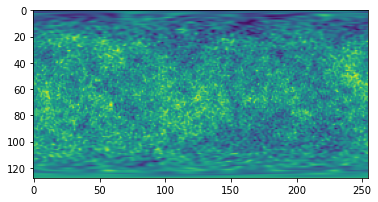

In [41]:
plt.imshow(hp_fits_map_to_MW_map(path))

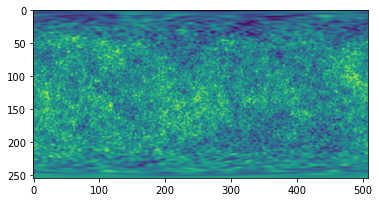

In [38]:
plt.imshow(MW_Map_doubleworker(MW_map))

Original map alm shape: (128, 255)


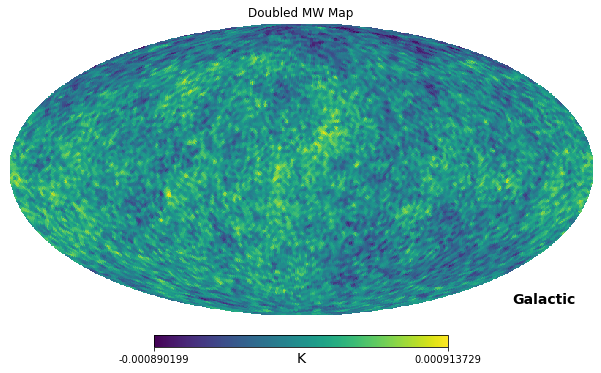

Original map alm shape: (255, 509)


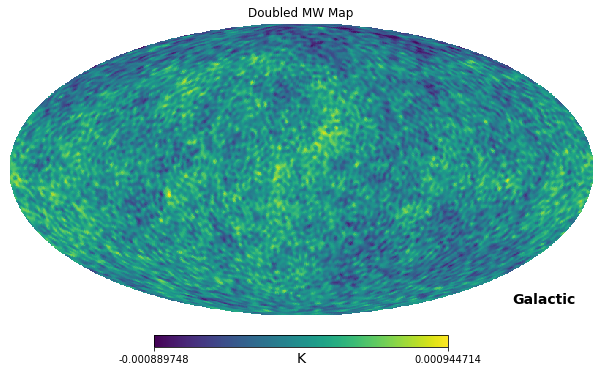

In [54]:

visualize_MW_Pix_map(MW_map,"Doubled MW Map")
visualize_MW_Pix_map(MW_Map_doubleworker(MW_map),"Doubled MW Map")

In [50]:
def mw_alm_2_hp_alm(MW_alm, lmax):
    '''MW_alm: 2D array of shape (Lmax, 2*Lmax-1) (MW sampling, McEwen & Wiaux)
    '''
    # Initialize the 1D hp_alm array with the appropriate size
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
        
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]

    return hp_alm

def visualize_MW_Pix_map(MW_Pix_Map, title, coord=["G"], unit = r"K", is_MW_alm = False):
    """
    Processes a MW pixel wavelet coefficient map and visualizes it using HEALPix mollview.

    Parameters:
        MW_Pix_Map (numpy array): Array representing the wavelet coefficient map.
        title (str): Title for the visualization plot.

    Returns:
        Only Displays a mollview map.
    """
    if not is_MW_alm:
        # The newly generated wavelet coefficient map is in three dimensions
        if len(MW_Pix_Map.shape) == 3:
            L_max = MW_Pix_Map.shape[1]
        else:
            L_max = MW_Pix_Map.shape[0]
        original_map_alm = s2fft.forward(MW_Pix_Map, L=L_max)
        print("ME alm shape:", original_map_alm.shape)
    else:
        original_map_alm = MW_Pix_Map
        L_max = original_map_alm.shape[0]
    original_map_hp_alm = mw_alm_2_hp_alm(original_map_alm, L_max - 1)
    original_hp_map = hp.alm2map(original_map_hp_alm, nside=(L_max - 1)//2)

    hp.mollview(
        original_hp_map,
        coord=coord,
        title=title,
        unit=unit,
        # min=min, max=max,  # Uncomment and adjust these as necessary for better visualization contrast
    )
    # plt.figure(dpi=1200)
    plt.show()